## Introduction

Author: Brock Tubre

Course: CPCS 8100 Introduction to AI

Date: Friday, October, 18, 2019


During this notebook we will use various methods to create a baseline KMeans clustering on the dataset used in the paper. We will then go through a similar process as described in the paper on sparsifiying the dataset. We will measure the accuracy of each sparseifcaiton using different evaluation metrics similar to those used in the paper. [Here is a link to the paper](http://proceedings.mlr.press/v80/sinha18a/sinha18a.pdf). 

1. [Getting The Data Used in Paper](#Getting-The-Data-Used-in-Paper)
1. [Viewing The Training Data](#Viewing-The-Training-Data)
1. [Evaluating Model](#Evaluating-Model)
1. [Random Sparsification](#Random-Sparsification)
1. [Results](#Results)

In [220]:
import boto3
import numpy as np
import pandas as pd
from datetime import datetime

In [221]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session

role = get_execution_role()
bucket = Session().default_bucket()
region = boto3.Session().region_name

<br>


## Getting The Data Used in Paper
During this demonstration and work, I plan to only use one of the datasets described in the authors paper. This is for a couple of reasons. Mainly for time and simplicity reasons. 

The USPS dataset [Hull, 1994](https://ieeexplore.ieee.org/document/291440) contains 9298 handwritten digit images, where each 16 × 16 image is represented by a feature vector of length 256. The author originally seeks to find k = 10 clusters, one for each of the ten digits. Here is where the author and I both got the dataset from. [Link to dataset](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html).

So an entry in our dataset or matrix looks something like this:
2 1:-1.000000 2:-1.000000 3:-1.000000 4:-0.999997 ... 256:-0.649848

Where the first number is a category (numbers 0-9) and the remaining values are feature vectors. 

Since numpy arrays are a bit easier to work with, I converted the LIBSVM format to numpy arrays. 

In [222]:
boto3.Session().resource('s3', region_name=region).Bucket('cpsc-8100-data-bucket'.format(region)).download_file('usps/usps_train.libsvm', 'usps_train.libsvm')
boto3.Session().resource('s3', region_name=region).Bucket('cpsc-8100-data-bucket'.format(region)).download_file('usps/usps_test.libsvm', 'usps_test.libsvm')


from sklearn.datasets import load_svmlight_file

def get_training_data():
    data = load_svmlight_file('./usps_train.libsvm')
    return data[0], data[1]

X_train, y_train = get_training_data()

def get_testing_data():
    data = load_svmlight_file('./usps_test.libsvm')
    return data[0], data[1]

X_test, y_test = get_testing_data()

In [223]:
X_train_array = X_train.toarray().astype('float32')
X_test_array = X_test.toarray().astype('float32')

X_train_array_double = X_train.toarray().astype('double')
X_test_array_double = X_test.toarray().astype('double')

In [224]:
print('The training dataset has {} number of observations.'.format(len(X_train_array_double)))
print('The testing dataset has {} number of observations.'.format(len(X_test_array_double)))

The training dataset has 7291 number of observations.
The testing dataset has 2007 number of observations.


<br>


## Viewing The Training Data

In the next part, I wanted to take a look at the training data and view some of the entries. Here we can plot one of the feature vectors into a 16 x 16 and also show the cooresponding label associated with the observation.

In [225]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((16,16))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

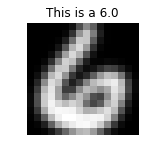

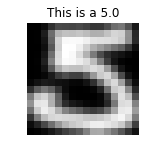

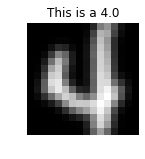

In [226]:
show_digit(X_train_array[0], 'This is a {}'.format(y_train[0]-1))
show_digit(X_train_array[1], 'This is a {}'.format(y_train[1]-1))
show_digit(X_train_array[2], 'This is a {}'.format(y_train[2]-1))

Let's take a look at the frequency of each category or digit.  The distribution looks pretty good. 0's and 1's have a few more than others, but still looks good. 5 and 6 are the lowest of all the distribution.

Training data has 664 number 6.0's as observations.
Training data has 556 number 5.0's as observations.
Training data has 652 number 4.0's as observations.
Training data has 645 number 7.0's as observations.
Training data has 658 number 3.0's as observations.
Training data has 1005 number 1.0's as observations.
Training data has 1194 number 0.0's as observations.
Training data has 542 number 8.0's as observations.
Training data has 731 number 2.0's as observations.
Training data has 644 number 9.0's as observations.


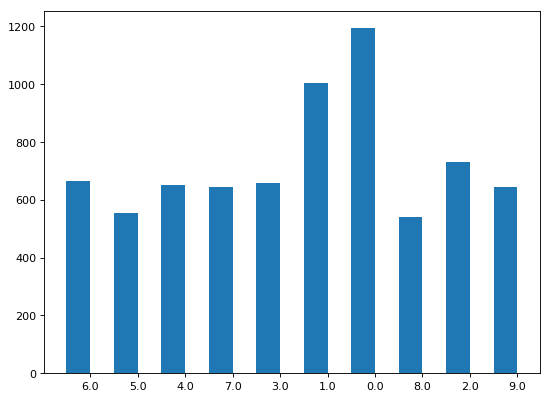

In [227]:
import collections
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
counter = collections.Counter(y_train-1)

for i in counter:
    print('Training data has {} number {}\'s as observations.'.format(counter[i], i))
    


labels, values = zip(*counter.items())

indexes = np.arange(len(labels))
width = 0.5
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

## Training The Model
Next, we will use the data to train of KMeans algorithm. In the paper the auther uses Lloyd’s heuristic for k-means clustering by applying Matlab’s kmeans function which, by default, uses kmeans++ algorithm [Arthur & Vassilvitskii, 2007](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf) for cluster center initialization. 

I will be using the same kmeans++ function but from the [Sci-kit Learn Python library](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

I will also be using another version of the kmeans++ funtion from [AWS KMeans Algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/k-means.html). 

In [228]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_train_array)

After the first model has finsih training we'll take a look at how the testing data is clustered and how they compare to other values in that cluster.

Most common value in cluster 0 is 4.0.
Most common value in cluster 1 is 1.0.
Most common value in cluster 2 is 0.0.
Most common value in cluster 3 is 8.0.
Most common value in cluster 4 is 9.0.
Most common value in cluster 5 is 3.0.
Most common value in cluster 6 is 0.0.
Most common value in cluster 7 is 7.0.
Most common value in cluster 8 is 2.0.
Most common value in cluster 9 is 6.0.

Cluster 0:


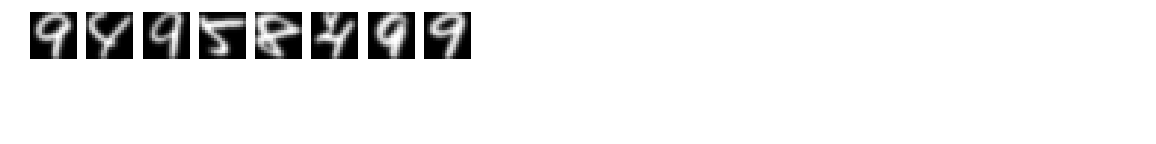


Cluster 1:


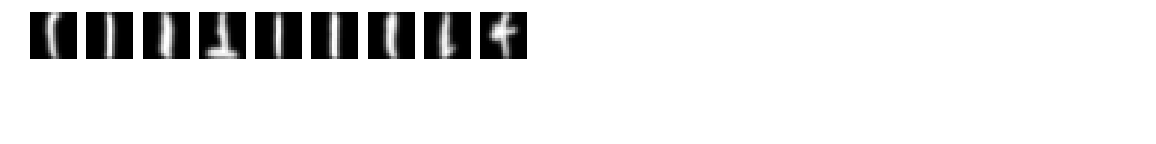


Cluster 2:


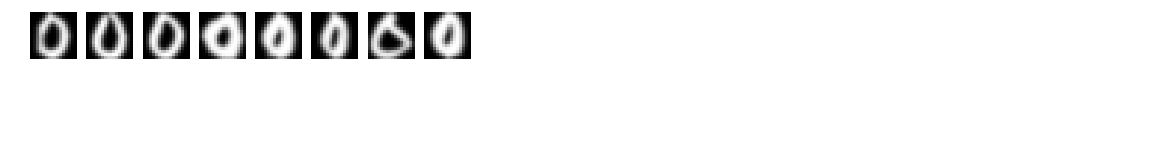


Cluster 3:


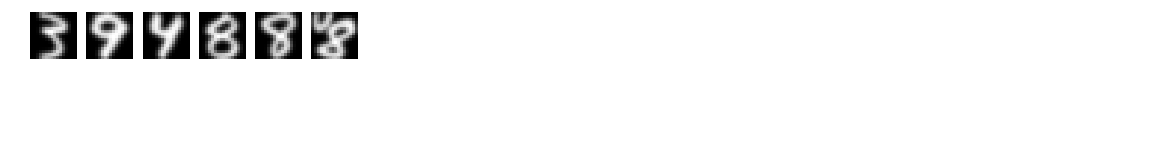


Cluster 4:


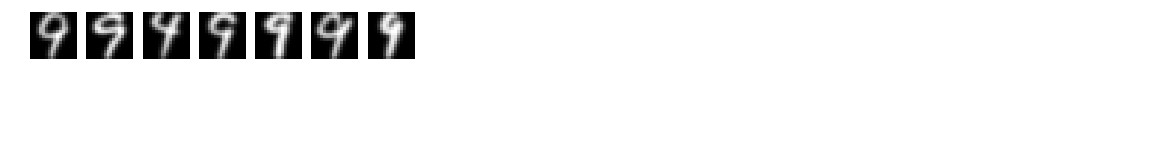


Cluster 5:


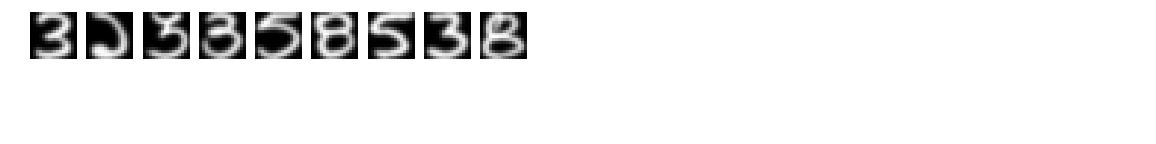


Cluster 6:


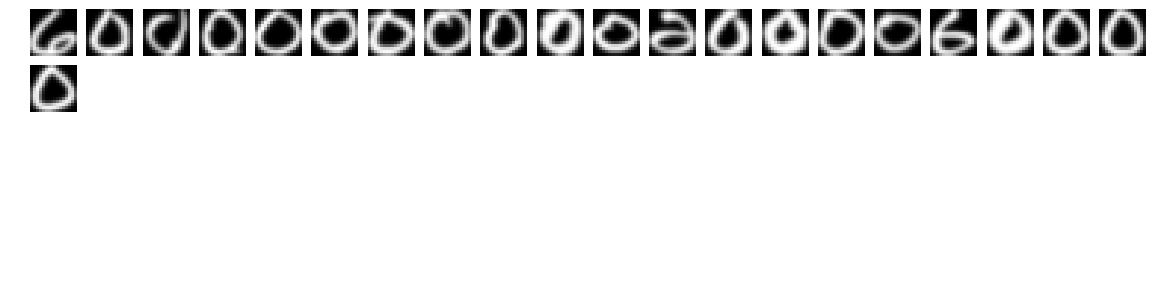


Cluster 7:


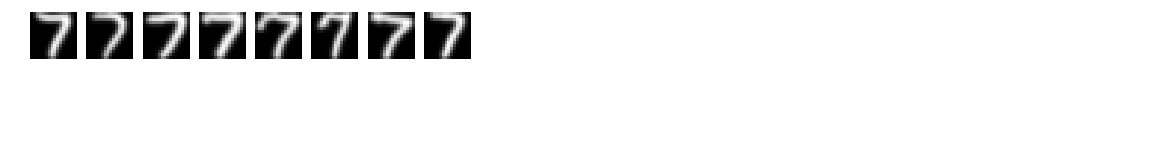


Cluster 8:


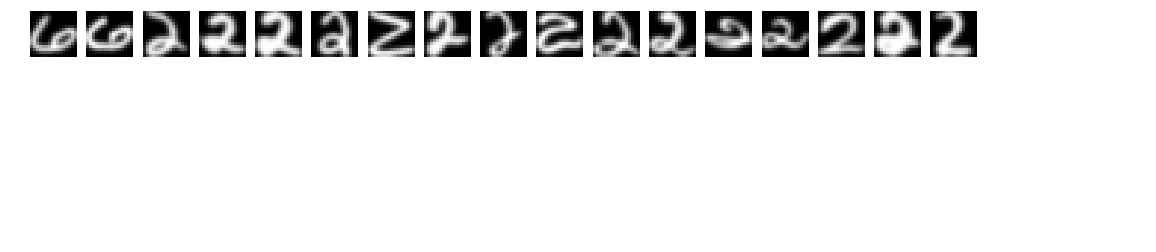


Cluster 9:


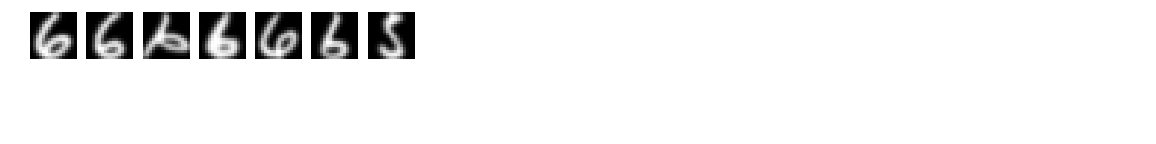

In [229]:
results = kmeans.predict(X_test_array)
clusters = results

most_common_val_cluster_0 = []
most_common_val_cluster_1 = []
most_common_val_cluster_2 = []
most_common_val_cluster_3 = []
most_common_val_cluster_4 = []
most_common_val_cluster_5 = []
most_common_val_cluster_6 = []
most_common_val_cluster_7 = []
most_common_val_cluster_8 = []
most_common_val_cluster_9 = []

def most_common(lst):
    return max(set(lst), key=lst.count)

for i, r in enumerate(clusters):
    if(r == 0):
        most_common_val_cluster_0.append(y_test[i]-1)
    if(r == 1):
        most_common_val_cluster_1.append(y_test[i]-1)
    if(r == 2):
        most_common_val_cluster_2.append(y_test[i]-1)
    if(r == 3):
        most_common_val_cluster_3.append(y_test[i]-1)
    if(r == 4):
        most_common_val_cluster_4.append(y_test[i]-1)
    if(r == 5):
        most_common_val_cluster_5.append(y_test[i]-1)
    if(r == 6):
        most_common_val_cluster_6.append(y_test[i]-1)
    if(r == 7):
        most_common_val_cluster_7.append(y_test[i]-1)
    if(r == 8):
        most_common_val_cluster_8.append(y_test[i]-1)
    if(r == 9):
        most_common_val_cluster_9.append(y_test[i]-1)


print('Most common value in cluster {} is {}.'.format(0, most_common(most_common_val_cluster_0)))
print('Most common value in cluster {} is {}.'.format(1, most_common(most_common_val_cluster_1)))
print('Most common value in cluster {} is {}.'.format(2, most_common(most_common_val_cluster_2)))
print('Most common value in cluster {} is {}.'.format(3, most_common(most_common_val_cluster_3)))
print('Most common value in cluster {} is {}.'.format(4, most_common(most_common_val_cluster_4)))
print('Most common value in cluster {} is {}.'.format(5, most_common(most_common_val_cluster_5)))
print('Most common value in cluster {} is {}.'.format(6, most_common(most_common_val_cluster_6)))
print('Most common value in cluster {} is {}.'.format(7, most_common(most_common_val_cluster_7)))
print('Most common value in cluster {} is {}.'.format(8, most_common(most_common_val_cluster_8)))
print('Most common value in cluster {} is {}.'.format(9, most_common(most_common_val_cluster_9)))

for cluster in range(10):
    print('\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, X_test_array[0:100]) if cluster == int(l)]
    height=((len(digits)-1)//5)+1
    width=20
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots=np.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()

It looks like the cluster 2 and cluster 6 both have 0 as the most common value. Lets take a look at the second most common value which is cluster 2 is 5. So we will mark cluster 2 as the predictor for 5.

In [230]:
import collections
counter=collections.Counter(most_common_val_cluster_2)
print(counter)

Counter({0.0: 150, 5.0: 12, 6.0: 5, 8.0: 3, 2.0: 3, 3.0: 2})


In [231]:
mapped_clusters = []

for i, r in enumerate(clusters):
    if(r == 0):
        mapped_clusters.append(6)
    if(r == 1):
        mapped_clusters.append(1)
    if(r == 2):
        mapped_clusters.append(5)
    if(r == 3):
        mapped_clusters.append(8)
    if(r == 4):
        mapped_clusters.append(9)
    if(r == 5):
        mapped_clusters.append(3)
    if(r == 6):
        mapped_clusters.append(0)
    if(r == 7):
        mapped_clusters.append(7)
    if(r == 8):
        mapped_clusters.append(2)
    if(r == 9):
        mapped_clusters.append(6)

<br>

## Evaluating Model
We will use the same methods that the paper uses to evaluate our baseline model. 
- Firstly, we will use the [completenes score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html#sklearn.metrics.completeness_score) which is the completeness metric of a cluster labeling given a ground truth. A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.
- Secondly, we will use the [homogeneity metric](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html#sklearn.metrics.homogeneity_score) of a cluster labeling given a ground truth. A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.
- Thirdly, we will look at the [v-measure score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html#sklearn.metrics.v_measure_score) which is the harmonic mean between homogeneity and completeness.

These will be our baseline modles that we will use to compare to after sparsification.

In [232]:
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import v_measure_score

print('The completness score is {}.'.format(completeness_score(mapped_clusters, y_test)))
print('The homoeneity score is {}.'.format(homogeneity_score(mapped_clusters, y_test)))
print('The v-means score is {}.'.format(v_measure_score(mapped_clusters, y_test)))

The completness score is 0.5394985567670652.
The homoeneity score is 0.5706099316295998.
The v-means score is 0.5546182878679584.


<br>

## Random Sparsification
After applying the USPS dataset to the KMeans algorithms and forming a baseline model. The next step the author does is apply random sparsecification to the matrix dataset then evaluates the results. The top portion of the graphic is what we are accomplishing through out the next few steps. We will evaluate the model after each sparsification. 

<img src="./sparse.png">

In [233]:
from scipy.sparse import random
from scipy import stats

class CustomRandomState(np.random.RandomState):
    def randint(self, k):
        i = np.random.randint(k)
        return i - i % 2
np.random.seed(12345)
rs = CustomRandomState()
rvs = stats.poisson(25, loc=10).rvs
S = random(len(X_train_array), 256, density=0.90, random_state=rs, data_rvs=rvs)
S.A

mask = (S.A == 0)

In [234]:
X_train_sparse = X_train_array
X_train_sparse[mask] = mask[mask]
np.where(X_train_sparse==1, -1, X_train_sparse)

array([[-1.      , -1.      , -1.      , ..., -1.      , -0.999475,
        -0.999994],
       [-0.999927, -0.993644, -0.900309, ..., -0.32939 , -0.584681,
        -0.868793],
       [-1.      , -1.      , -1.      , ..., -0.988116, -0.999864,
        -1.      ],
       ...,
       [-0.998491, -0.971247, -0.824413, ..., -0.99315 , -0.999791,
        -0.999998],
       [-0.999999, -0.999893, -0.995429, ..., -0.942224, -1.      ,
        -0.996327],
       [-1.      , -1.      , -0.999874, ..., -1.      , -1.      ,
        -1.      ]], dtype=float32)

Now that we have a more sparse data matrix, in this case 10% of the values have been removed. Lets give it a go.

In [235]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_train_sparse)

Most common value in cluster 0 is 0.0.
Most common value in cluster 1 is 3.0.
Most common value in cluster 2 is 9.0.
Most common value in cluster 3 is 8.0.
Most common value in cluster 4 is 2.0.
Most common value in cluster 5 is 1.0.
Most common value in cluster 6 is 4.0.
Most common value in cluster 7 is 6.0.
Most common value in cluster 8 is 7.0.
Most common value in cluster 9 is 0.0.

Cluster 0:


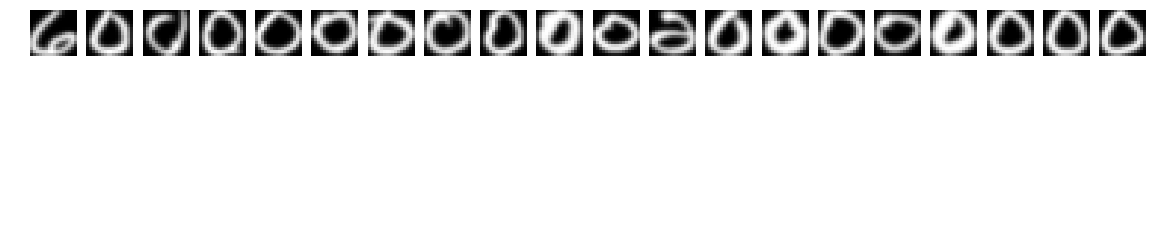


Cluster 1:


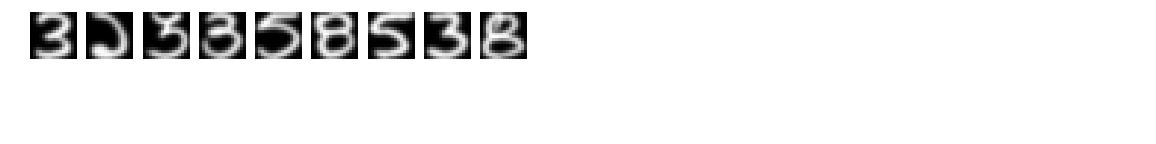


Cluster 2:


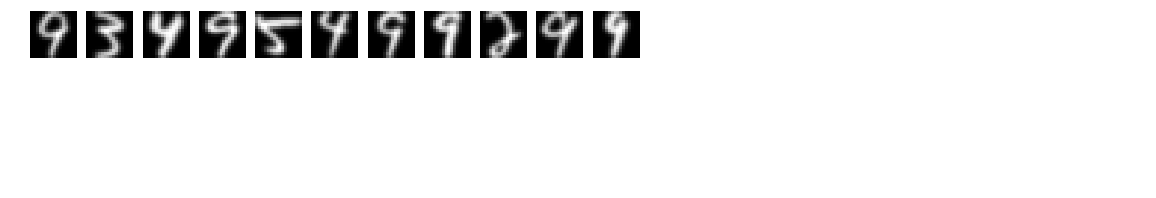


Cluster 3:


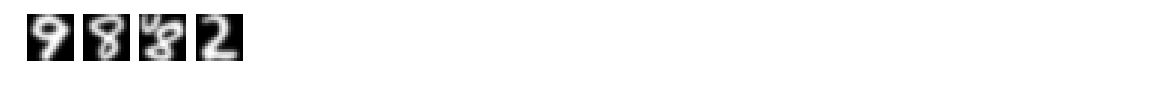


Cluster 4:


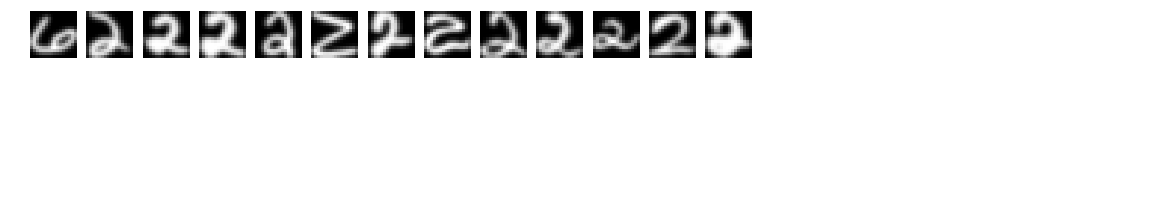


Cluster 5:


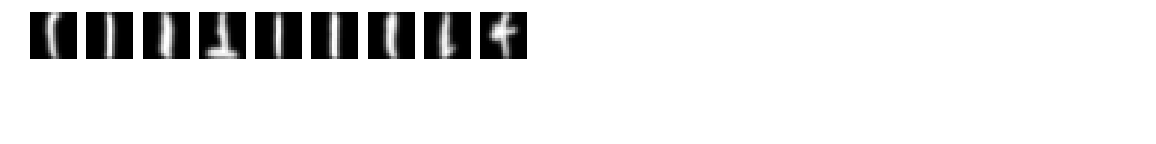


Cluster 6:


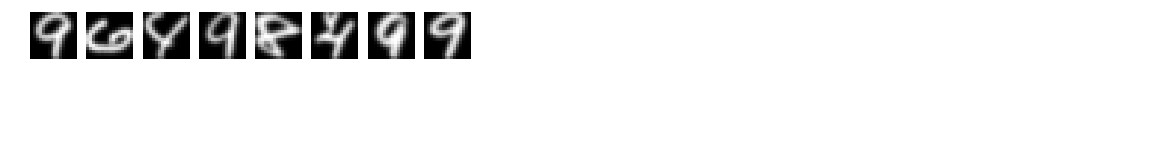


Cluster 7:


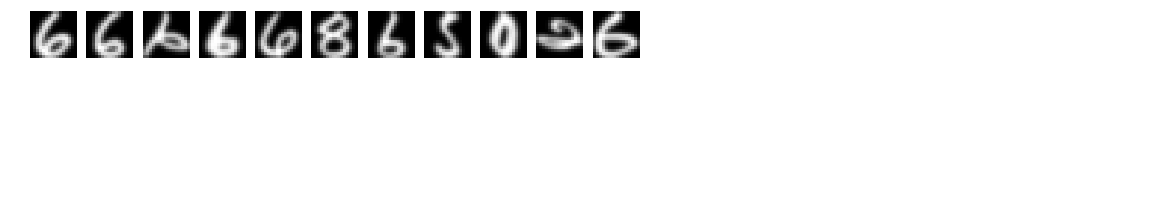


Cluster 8:


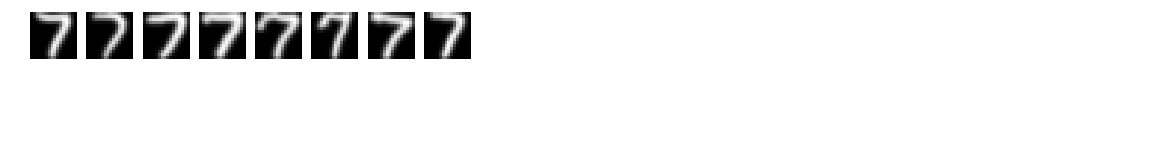


Cluster 9:


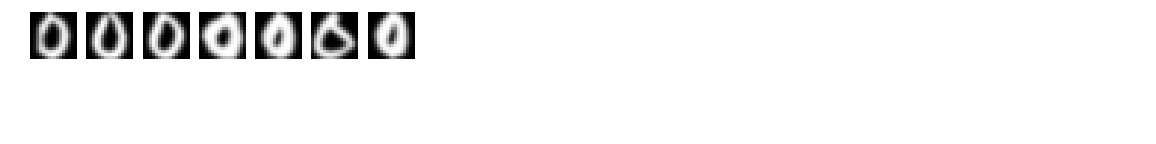

In [236]:
results = kmeans.predict(X_test_array)
clusters = results

most_common_val_cluster_0 = []
most_common_val_cluster_1 = []
most_common_val_cluster_2 = []
most_common_val_cluster_3 = []
most_common_val_cluster_4 = []
most_common_val_cluster_5 = []
most_common_val_cluster_6 = []
most_common_val_cluster_7 = []
most_common_val_cluster_8 = []
most_common_val_cluster_9 = []

def most_common(lst):
    return max(set(lst), key=lst.count)

for i, r in enumerate(clusters):
    if(r == 0):
        most_common_val_cluster_0.append(y_test[i]-1)
    if(r == 1):
        most_common_val_cluster_1.append(y_test[i]-1)
    if(r == 2):
        most_common_val_cluster_2.append(y_test[i]-1)
    if(r == 3):
        most_common_val_cluster_3.append(y_test[i]-1)
    if(r == 4):
        most_common_val_cluster_4.append(y_test[i]-1)
    if(r == 5):
        most_common_val_cluster_5.append(y_test[i]-1)
    if(r == 6):
        most_common_val_cluster_6.append(y_test[i]-1)
    if(r == 7):
        most_common_val_cluster_7.append(y_test[i]-1)
    if(r == 8):
        most_common_val_cluster_8.append(y_test[i]-1)
    if(r == 9):
        most_common_val_cluster_9.append(y_test[i]-1)


print('Most common value in cluster {} is {}.'.format(0, most_common(most_common_val_cluster_0)))
print('Most common value in cluster {} is {}.'.format(1, most_common(most_common_val_cluster_1)))
print('Most common value in cluster {} is {}.'.format(2, most_common(most_common_val_cluster_2)))
print('Most common value in cluster {} is {}.'.format(3, most_common(most_common_val_cluster_3)))
print('Most common value in cluster {} is {}.'.format(4, most_common(most_common_val_cluster_4)))
print('Most common value in cluster {} is {}.'.format(5, most_common(most_common_val_cluster_5)))
print('Most common value in cluster {} is {}.'.format(6, most_common(most_common_val_cluster_6)))
print('Most common value in cluster {} is {}.'.format(7, most_common(most_common_val_cluster_7)))
print('Most common value in cluster {} is {}.'.format(8, most_common(most_common_val_cluster_8)))
print('Most common value in cluster {} is {}.'.format(9, most_common(most_common_val_cluster_9)))

for cluster in range(10):
    print('\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, X_test_array[0:100]) if cluster == int(l)]
    height=((len(digits)-1)//5)+1
    width=20
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots=np.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()

In [237]:
import collections
counter=collections.Counter(most_common_val_cluster_6)
print(counter)

Counter({4.0: 102, 9.0: 25, 2.0: 12, 5.0: 9, 6.0: 4, 7.0: 4, 8.0: 3, 1.0: 3, 0.0: 2})


In [238]:
mapped_clusters = []

for i, r in enumerate(clusters):
    if(r == 0):
        mapped_clusters.append(6)
    if(r == 1):
        mapped_clusters.append(9)
    if(r == 2):
        mapped_clusters.append(0)
    if(r == 3):
        mapped_clusters.append(8)
    if(r == 4):
        mapped_clusters.append(9)
    if(r == 5):
        mapped_clusters.append(3)
    if(r == 6):
        mapped_clusters.append(5)
    if(r == 7):
        mapped_clusters.append(1)
    if(r == 8):
        mapped_clusters.append(4)
    if(r == 9):
        mapped_clusters.append(2)

In [239]:
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import v_measure_score

print('The completness score is {}.'.format(completeness_score(mapped_clusters, y_test)))
print('The homoeneity score is {}.'.format(homogeneity_score(mapped_clusters, y_test)))
print('The homoeneity score is {}.'.format(v_measure_score(mapped_clusters, y_test)))

The completness score is 0.49314451042241886.
The homoeneity score is 0.5275267941406916.
The homoeneity score is 0.5097565523164643.


So, we can clearly see that the ratio of correct classifications is going down, just like the paper refernces. If we run this enough times we should see the decay in values as we make our dataset more and more sparse. 

Now we are going to sparsify the matrix even more. We are making 50% of the values zero entries. 

In [240]:
from scipy.sparse import random
from scipy import stats

class CustomRandomState(np.random.RandomState):
    def randint(self, k):
        i = np.random.randint(k)
        return i - i % 2
np.random.seed(12345)
rs = CustomRandomState()
rvs = stats.poisson(25, loc=10).rvs
S = random(len(X_train_array), 256, density=0.90, random_state=rs, data_rvs=rvs)
S.A

mask = (S.A == 0)

In [241]:
X_train_sparse = X_train_array
X_train_sparse[mask] = mask[mask]
np.where(X_train_sparse==1, -1, X_train_sparse)

array([[-1.      , -1.      , -1.      , ..., -1.      , -0.999475,
        -0.999994],
       [-0.999927, -0.993644, -0.900309, ..., -0.32939 , -0.584681,
        -0.868793],
       [-1.      , -1.      , -1.      , ..., -0.988116, -0.999864,
        -1.      ],
       ...,
       [-0.998491, -0.971247, -0.824413, ..., -0.99315 , -0.999791,
        -1.      ],
       [-0.999999, -0.999893, -0.995429, ..., -0.942224, -1.      ,
        -0.996327],
       [-1.      , -1.      , -0.999874, ..., -1.      , -1.      ,
        -1.      ]], dtype=float32)

Now that we have a more sparse data matrix, in this case 10% of the values have been removed. Lets give it a go.

In [242]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_train_sparse)

Most common value in cluster 0 is 4.0.
Most common value in cluster 1 is 3.0.
Most common value in cluster 2 is 8.0.
Most common value in cluster 3 is 7.0.
Most common value in cluster 4 is 1.0.
Most common value in cluster 5 is 0.0.
Most common value in cluster 6 is 0.0.
Most common value in cluster 7 is 2.0.
Most common value in cluster 8 is 9.0.
Most common value in cluster 9 is 6.0.

Cluster 0:


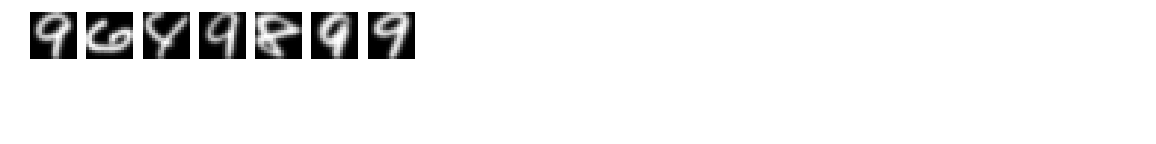


Cluster 1:


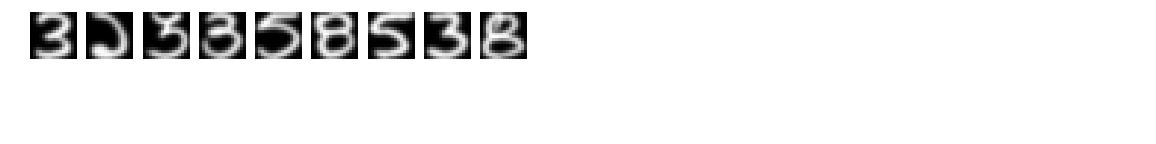


Cluster 2:


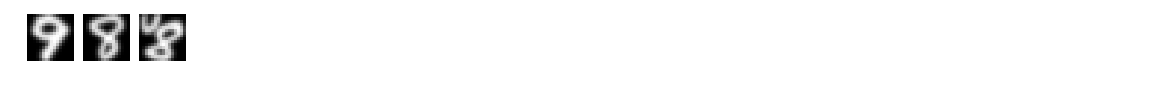


Cluster 3:


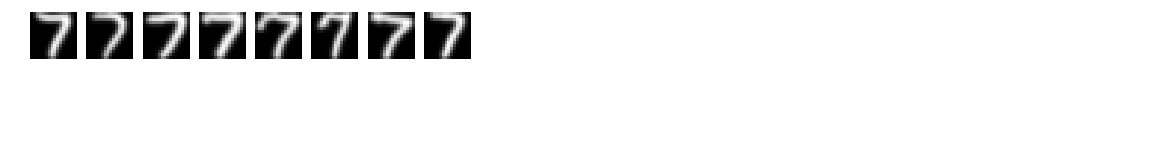


Cluster 4:


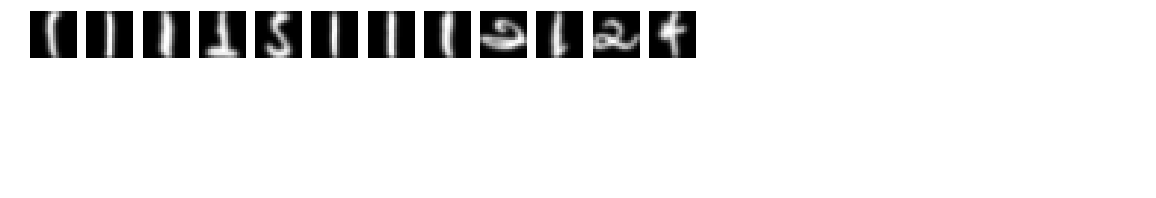


Cluster 5:


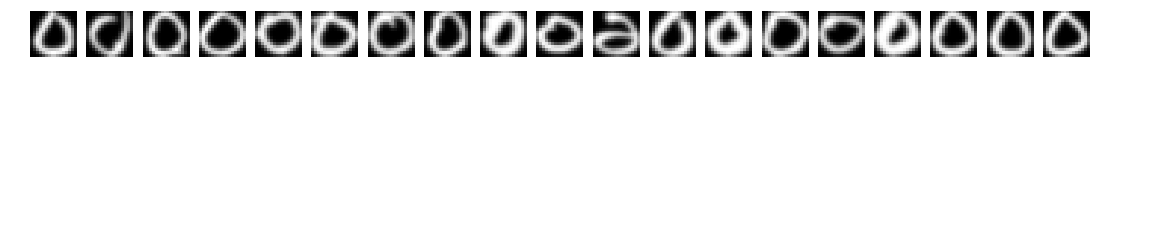


Cluster 6:


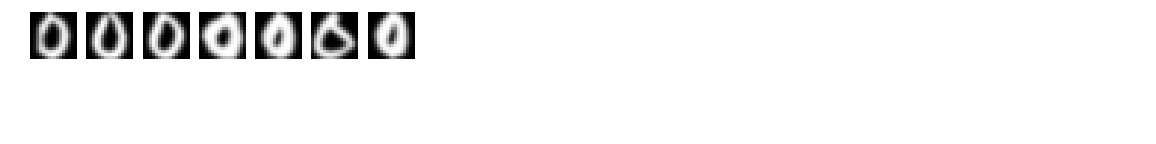


Cluster 7:


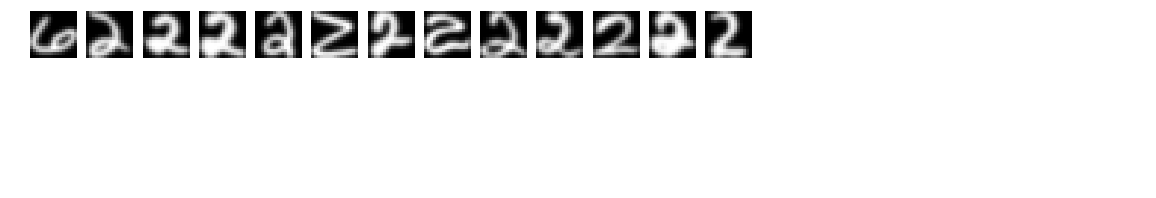


Cluster 8:


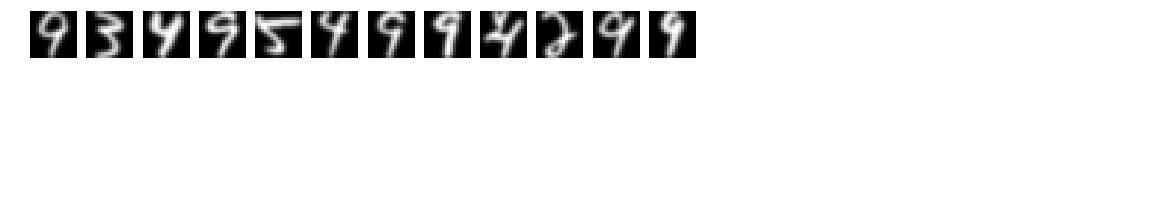


Cluster 9:


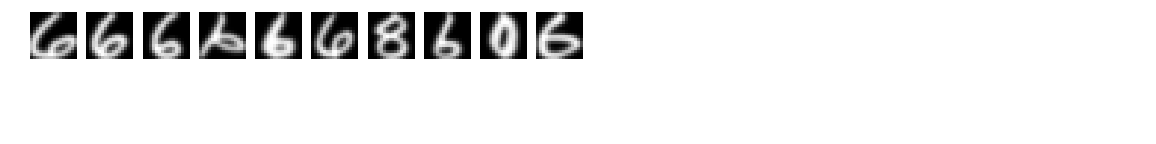

In [243]:
results = kmeans.predict(X_test_array)
clusters = results

most_common_val_cluster_0 = []
most_common_val_cluster_1 = []
most_common_val_cluster_2 = []
most_common_val_cluster_3 = []
most_common_val_cluster_4 = []
most_common_val_cluster_5 = []
most_common_val_cluster_6 = []
most_common_val_cluster_7 = []
most_common_val_cluster_8 = []
most_common_val_cluster_9 = []

def most_common(lst):
    return max(set(lst), key=lst.count)

for i, r in enumerate(clusters):
    if(r == 0):
        most_common_val_cluster_0.append(y_test[i]-1)
    if(r == 1):
        most_common_val_cluster_1.append(y_test[i]-1)
    if(r == 2):
        most_common_val_cluster_2.append(y_test[i]-1)
    if(r == 3):
        most_common_val_cluster_3.append(y_test[i]-1)
    if(r == 4):
        most_common_val_cluster_4.append(y_test[i]-1)
    if(r == 5):
        most_common_val_cluster_5.append(y_test[i]-1)
    if(r == 6):
        most_common_val_cluster_6.append(y_test[i]-1)
    if(r == 7):
        most_common_val_cluster_7.append(y_test[i]-1)
    if(r == 8):
        most_common_val_cluster_8.append(y_test[i]-1)
    if(r == 9):
        most_common_val_cluster_9.append(y_test[i]-1)


print('Most common value in cluster {} is {}.'.format(0, most_common(most_common_val_cluster_0)))
print('Most common value in cluster {} is {}.'.format(1, most_common(most_common_val_cluster_1)))
print('Most common value in cluster {} is {}.'.format(2, most_common(most_common_val_cluster_2)))
print('Most common value in cluster {} is {}.'.format(3, most_common(most_common_val_cluster_3)))
print('Most common value in cluster {} is {}.'.format(4, most_common(most_common_val_cluster_4)))
print('Most common value in cluster {} is {}.'.format(5, most_common(most_common_val_cluster_5)))
print('Most common value in cluster {} is {}.'.format(6, most_common(most_common_val_cluster_6)))
print('Most common value in cluster {} is {}.'.format(7, most_common(most_common_val_cluster_7)))
print('Most common value in cluster {} is {}.'.format(8, most_common(most_common_val_cluster_8)))
print('Most common value in cluster {} is {}.'.format(9, most_common(most_common_val_cluster_9)))

for cluster in range(10):
    print('\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, X_test_array[0:100]) if cluster == int(l)]
    height=((len(digits)-1)//5)+1
    width=20
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots=np.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()

In [244]:
import collections
counter=collections.Counter(most_common_val_cluster_6)
print(counter)

Counter({0.0: 125, 5.0: 3, 8.0: 2, 2.0: 1})


In [245]:
mapped_clusters = []

for i, r in enumerate(clusters):
    if(r == 0):
        mapped_clusters.append(6)
    if(r == 1):
        mapped_clusters.append(9)
    if(r == 2):
        mapped_clusters.append(0)
    if(r == 3):
        mapped_clusters.append(8)
    if(r == 4):
        mapped_clusters.append(9)
    if(r == 5):
        mapped_clusters.append(3)
    if(r == 6):
        mapped_clusters.append(5)
    if(r == 7):
        mapped_clusters.append(1)
    if(r == 8):
        mapped_clusters.append(4)
    if(r == 9):
        mapped_clusters.append(2)

In [246]:
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import v_measure_score

print('The completness score is {}.'.format(completeness_score(mapped_clusters, y_test)))
print('The homoeneity score is {}.'.format(homogeneity_score(mapped_clusters, y_test)))
print('The homoeneity score is {}.'.format(v_measure_score(mapped_clusters, y_test)))

The completness score is 0.4072442020458292.
The homoeneity score is 0.47627126921255225.
The homoeneity score is 0.43906127124535094.


So, we can clearly see that the ratio of correct classifications is going down, just like the paper refernces. If we run this enough times we should see the decay in values as we make our dataset more and more sparse. 

<br>

## Random Sparsification (50 %)
In this section we will randomly sparsify the data by 50%.

In [247]:
from scipy.sparse import random
from scipy import stats

class CustomRandomState(np.random.RandomState):
    def randint(self, k):
        i = np.random.randint(k)
        return i - i % 2
np.random.seed(12345)
rs = CustomRandomState()
rvs = stats.poisson(25, loc=10).rvs
S = random(len(X_train_array), 256, density=0.50, random_state=rs, data_rvs=rvs)
S.A

mask = (S.A == 0)

In [248]:
X_train_sparse = X_train_array
X_train_sparse[mask] = mask[mask]
np.where(X_train_sparse==1, -1, X_train_sparse)

array([[-1.      , -1.      , -1.      , ..., -1.      , -1.      ,
        -1.      ],
       [-0.999927, -0.993644, -0.900309, ..., -0.32939 , -1.      ,
        -1.      ],
       [-1.      , -1.      , -1.      , ..., -0.988116, -0.999864,
        -1.      ],
       ...,
       [-0.998491, -1.      , -0.824413, ..., -1.      , -1.      ,
        -1.      ],
       [-0.999999, -1.      , -0.995429, ..., -0.942224, -1.      ,
        -1.      ],
       [-1.      , -1.      , -1.      , ..., -1.      , -1.      ,
        -1.      ]], dtype=float32)

Now that we have a more sparse data matrix, in this case 10% of the values have been removed. Lets give it a go.

In [249]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_train_sparse)

Most common value in cluster 0 is 3.0.
Most common value in cluster 1 is 4.0.
Most common value in cluster 2 is 0.0.
Most common value in cluster 3 is 0.0.
Most common value in cluster 4 is 8.0.
Most common value in cluster 5 is 1.0.
Most common value in cluster 6 is 4.0.
Most common value in cluster 7 is 0.0.
Most common value in cluster 8 is 7.0.
Most common value in cluster 9 is 2.0.

Cluster 0:


<Figure size 1440x0 with 0 Axes>


Cluster 1:


<Figure size 1440x0 with 0 Axes>


Cluster 2:


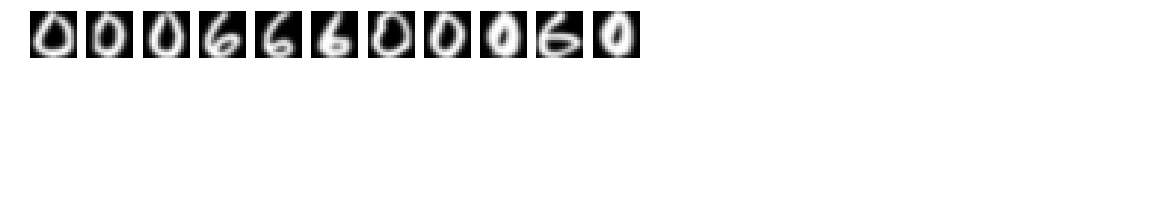


Cluster 3:


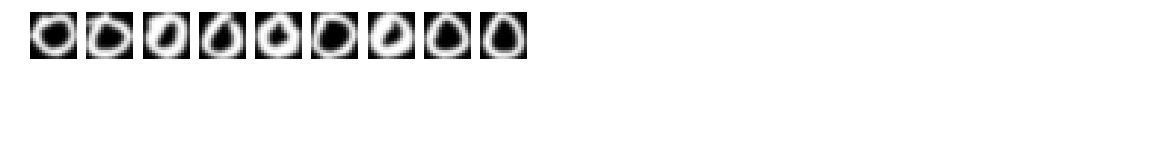


Cluster 4:


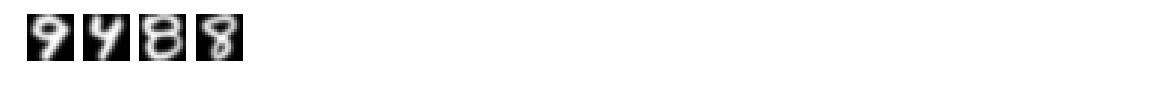


Cluster 5:


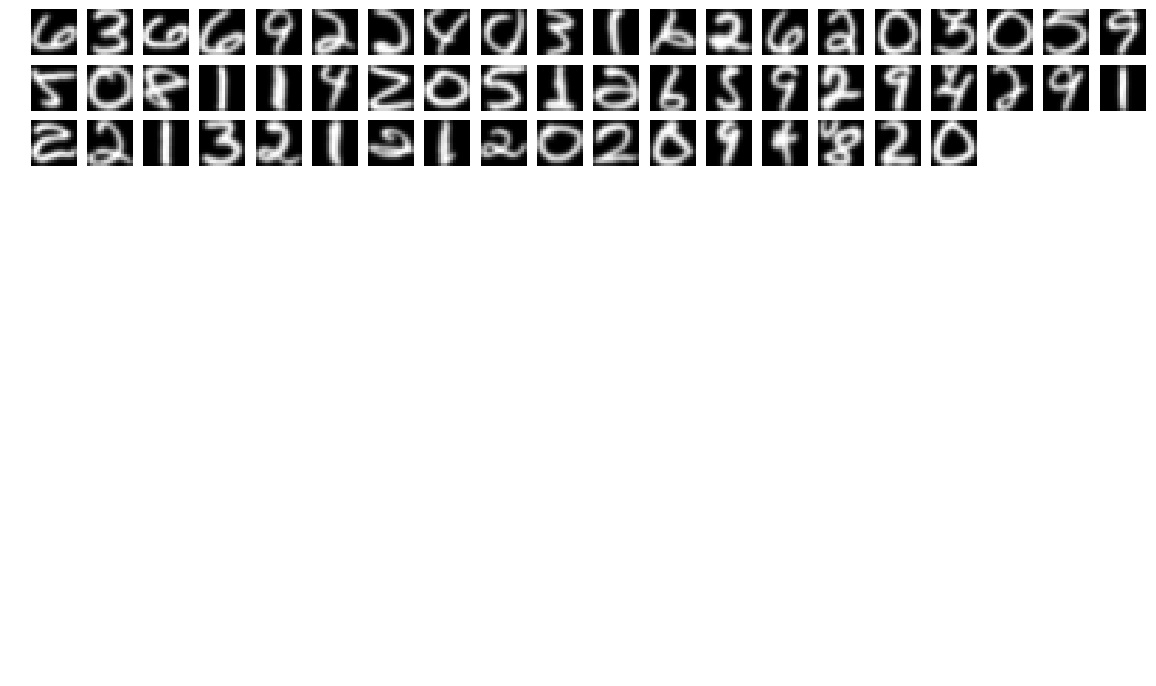


Cluster 6:


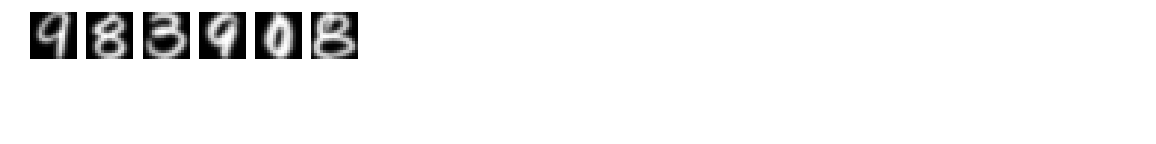


Cluster 7:


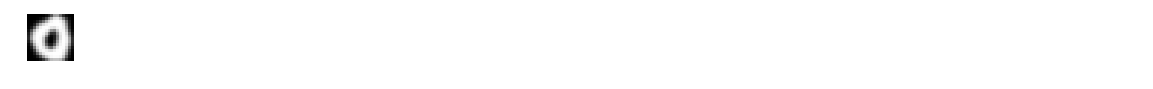


Cluster 8:


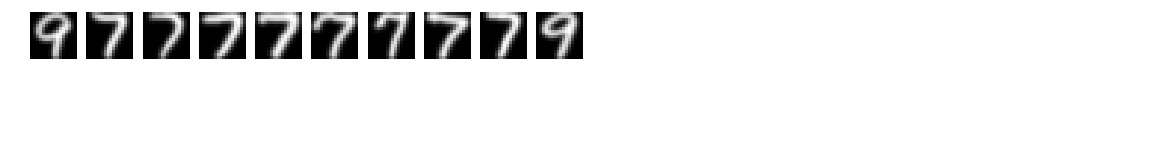


Cluster 9:


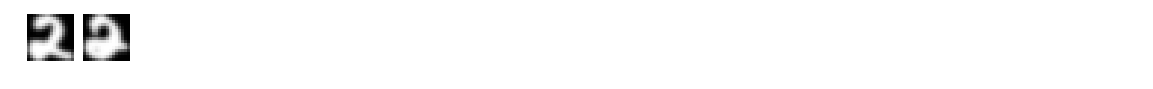

In [250]:
results = kmeans.predict(X_test_array)
clusters = results

most_common_val_cluster_0 = []
most_common_val_cluster_1 = []
most_common_val_cluster_2 = []
most_common_val_cluster_3 = []
most_common_val_cluster_4 = []
most_common_val_cluster_5 = []
most_common_val_cluster_6 = []
most_common_val_cluster_7 = []
most_common_val_cluster_8 = []
most_common_val_cluster_9 = []

def most_common(lst):
    return max(set(lst), key=lst.count)

for i, r in enumerate(clusters):
    if(r == 0):
        most_common_val_cluster_0.append(y_test[i]-1)
    if(r == 1):
        most_common_val_cluster_1.append(y_test[i]-1)
    if(r == 2):
        most_common_val_cluster_2.append(y_test[i]-1)
    if(r == 3):
        most_common_val_cluster_3.append(y_test[i]-1)
    if(r == 4):
        most_common_val_cluster_4.append(y_test[i]-1)
    if(r == 5):
        most_common_val_cluster_5.append(y_test[i]-1)
    if(r == 6):
        most_common_val_cluster_6.append(y_test[i]-1)
    if(r == 7):
        most_common_val_cluster_7.append(y_test[i]-1)
    if(r == 8):
        most_common_val_cluster_8.append(y_test[i]-1)
    if(r == 9):
        most_common_val_cluster_9.append(y_test[i]-1)


print('Most common value in cluster {} is {}.'.format(0, most_common(most_common_val_cluster_0)))
print('Most common value in cluster {} is {}.'.format(1, most_common(most_common_val_cluster_1)))
print('Most common value in cluster {} is {}.'.format(2, most_common(most_common_val_cluster_2)))
print('Most common value in cluster {} is {}.'.format(3, most_common(most_common_val_cluster_3)))
print('Most common value in cluster {} is {}.'.format(4, most_common(most_common_val_cluster_4)))
print('Most common value in cluster {} is {}.'.format(5, most_common(most_common_val_cluster_5)))
print('Most common value in cluster {} is {}.'.format(6, most_common(most_common_val_cluster_6)))
print('Most common value in cluster {} is {}.'.format(7, most_common(most_common_val_cluster_7)))
print('Most common value in cluster {} is {}.'.format(8, most_common(most_common_val_cluster_8)))
print('Most common value in cluster {} is {}.'.format(9, most_common(most_common_val_cluster_9)))

for cluster in range(10):
    print('\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, X_test_array[0:100]) if cluster == int(l)]
    height=((len(digits)-1)//5)+1
    width=20
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots=np.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()

In [251]:
mapped_clusters = []

for i, r in enumerate(clusters):
    if(r == 0):
        mapped_clusters.append(0)
    if(r == 1):
        mapped_clusters.append(0)
    if(r == 2):
        mapped_clusters.append(0)
    if(r == 3):
        mapped_clusters.append(7)
    if(r == 4):
        mapped_clusters.append(4)
    if(r == 5):
        mapped_clusters.append(2)
    if(r == 6):
        mapped_clusters.append(3)
    if(r == 7):
        mapped_clusters.append(8)
    if(r == 8):
        mapped_clusters.append(1)
    if(r == 9):
        mapped_clusters.append(0)

In [252]:
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import v_measure_score

print('The completness score is {}.'.format(completeness_score(mapped_clusters, y_test)))
print('The homoeneity score is {}.'.format(homogeneity_score(mapped_clusters, y_test)))
print('The homoeneity score is {}.'.format(v_measure_score(mapped_clusters, y_test)))

The completness score is 0.15470851468692848.
The homoeneity score is 0.30371849895018715.
The homoeneity score is 0.2049959381002875.


## Results

So, we can clearly see that the ratio of correct classifications is going down, just like the paper refernces. Once we continue this prcocess we will see the decrease continue. The author has then shows his results which are displayed below. Basically the q is the fraction of zero entries (or sparsified entries) and hi(q)is the metric function used to evaluate k-means cluster results. What his shows is the effect of random sparsification obtained by uniform and non-uniform sampling on k-means clustering. In all the subplots, red curve indicates uniform sampling and blue curve indicated non-uniform sampling. The black line in the second row indicates normalized mutual information obtained by performing k-means clustering on the original data set. For uniform sampling, p simply indicates that p fraction of entries of the sparsified dataset are non-zero. For non-uniform sampling, the authors uses improved uniform sampling techniques by retaining entries with probability that depends on their magnitude.

<img src="./graphs.png" />